In [1]:
import numpy as np
import pandas as pd
from carbon_models import *
pd.options.plotting.backend = "plotly"

In [2]:
# Import data
df_carbon = pd.read_csv("../Data/carbon_data_2022.csv",sep=",")
df_carbon.columns

Index(['Date', 'Region', 'saison', 'week_day', 'is_holiday', 'is_bank_holiday',
       'Temp', 'Temp1', 'Temp2', 'Temp3', 'Temp4', 'Temp5', 'Temp6', 'Temp7',
       'ratio_cge', 'c', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 't', 'r',
       'Emissions'],
      dtype='object')

In [3]:
# Define parameters
train_start = '2019-01-01'
train_end = '2022-01-01'
test_end = '2022-12-31'

selected_vars = [
    "Region",
    "Temp",
    "saison",
    "week_day",
    "is_holiday",
    "is_bank_holiday",
    "c",
    "t",
    "r",
]

# selected_vars = None

In [4]:
# Train the model and predict
output_df, model = LSTM_predict(df_carbon,train_start,train_end,test_end,selected_vars)
# output_df, model = Catboost_predict(df_carbon,train_start,train_end,test_end,selected_vars)
# output_df, model = Xgboost_predict(df_carbon,train_start,train_end,test_end,selected_vars)

X_train, X_test, _, _, _, _ = encode_normalize(df_carbon,train_start,train_end,test_end,selected_vars)


Epoch 1/50

206/206 [==============================] - 7s 14ms/step - loss: 0.6176 - val_loss: 0.5360
Epoch 2/50
206/206 [==============================] - 2s 10ms/step - loss: 0.4429 - val_loss: 0.5037
Epoch 3/50
206/206 [==============================] - 2s 9ms/step - loss: 0.4092 - val_loss: 0.5013
Epoch 4/50
206/206 [==============================] - 2s 11ms/step - loss: 0.3781 - val_loss: 0.4657
Epoch 5/50
206/206 [==============================] - 1s 7ms/step - loss: 0.3559 - val_loss: 0.4748
Epoch 6/50
206/206 [==============================] - 2s 10ms/step - loss: 0.3358 - val_loss: 0.4499
Epoch 7/50
206/206 [==============================] - 2s 7ms/step - loss: 0.3318 - val_loss: 0.4369
Epoch 8/50
206/206 [==============================] - 2s 9ms/step - loss: 0.3206 - val_loss: 0.4462
Epoch 9/50
206/206 [==============================] - 2s 8ms/step - loss: 0.3089 - val_loss: 0.4382
Epoch 10/50
206/206 [==============================] - 2s 10ms/step - loss: 0.3033 - val_loss:

In [5]:
output_df

,Date,Region,y,y_pred
0,2019-01-01,Auvergne-Rhône-Alpes,0.006316,NaN
1,2019-01-01,Bourgogne-Franche-Comté,0.002170,NaN
2,2019-01-01,Bretagne,0.002890,NaN
3,2019-01-01,Centre-Val de Loire,0.001938,NaN
4,2019-01-01,Grand Est,0.004186,NaN
...,...,...,...,...
17527,2022-12-31,Nouvelle-Aquitaine,0.004107,0.006930
17528,2022-12-31,Occitanie,0.003965,0.007754
17529,2022-12-31,Pays de la Loire,0.002540,0.008625
17530,2022-12-31,Provence-Alpes-Côte d'Azur,0.003703,0.010183


In [6]:
# Plot for the whole country
output_df.groupby(['Date']).apply(pd.DataFrame.sum,skipna=False).drop(columns=['Date','Region']).plot(title='France').update_layout(
    xaxis_title="Date", yaxis_title="Emissions (Mt/CO2)"
)

In [7]:
# Plot for the region `reg`
REGIONS = np.unique(df_carbon['Region'])
reg = REGIONS[8]

output_df[output_df['Region'] == reg].drop(columns='Region').set_index('Date').plot(title=reg).update_layout(
    xaxis_title="Date", yaxis_title="Emissions (Mt/CO2)"
)

In [8]:
is_test = (output_df['Date'] > train_end) * (output_df['Date'] <= test_end)

y_test = output_df['y'][is_test]
y_pred = output_df['y_pred'][is_test]

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2}")

# Evaluate using Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Squared Error (MSE): 1.805014642817677e-05
Root Mean Squared Error (RMSE): 0.004248546390022918
Mean Absolute Error (MAE): 0.0031306174166174515
Coefficient of Determination (R^2): 0.26389447030315283
Mean Absolute Percentage Error (MAPE): 0.411418152180435


We can use the SHAP (SHapley Additive exPlanations) library to explain the predictions of our model. We plot the impact of each feature on the model's predictions :

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
PermutationExplainer explainer: 4369it [22:53,  3.17it/s]                          


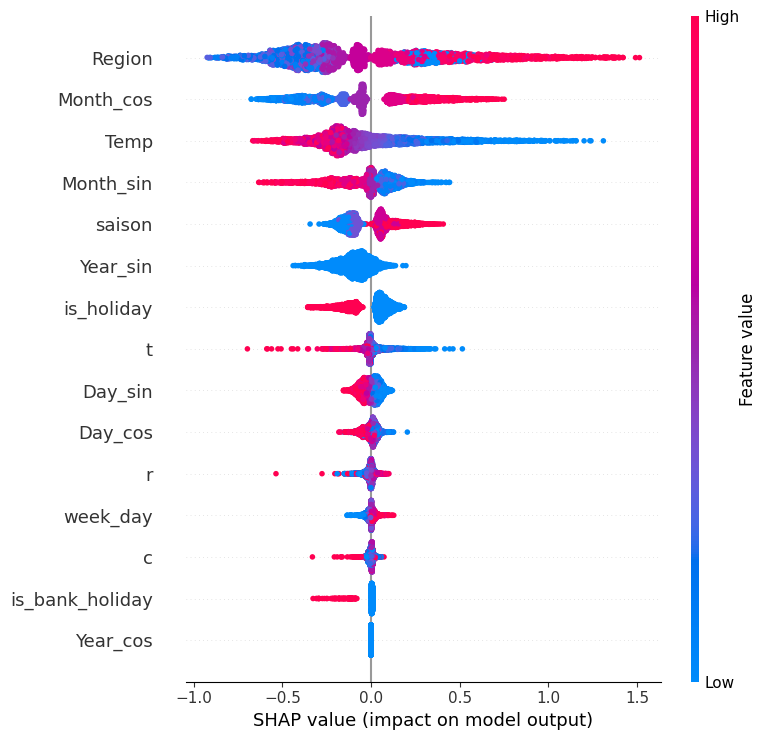

In [10]:
import shap

# Create a SHAP explainer for your model
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for your test data
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)